In [327]:
import json
import re
import os

In [328]:
def longest_common_substring(s1, s2):
    m = [[0] * (1 + len(s2)) for i in range(1 + len(s1))]
    longest, x_longest = 0, 0
    for x in range(1, 1 + len(s1)):
        for y in range(1, 1 + len(s2)):
            if s1[x - 1] == s2[y - 1]:
                m[x][y] = m[x - 1][y - 1] + 1
                if m[x][y] > longest:
                    longest = m[x][y]
                    x_longest = x
            else:
                m[x][y] = 0
    return s1[x_longest - longest: x_longest]



def evaluate_results(results_filepath, individual_results=False):
    data_final = []
    with open(results_filepath, 'r') as f:
        data = json.load(f)
    data_final += data

    individual_results_list = []

    i = 1
    p, r = 0, 0
    ac = 0
    for i, item in enumerate(data_final):
        pred = item['pred']
        res = ""
        correct=False

        # pattern = r": *([A-Z, ]+)\." # match the brick names between : and .
        # pattern = r"(?s): *([^:]*[A-Z, ]+)\." # match the brick names between : and .
        # pattern = r": *([A-Za-z, ]+)\."
        # pattern = r": *([A-Za-z, ]+)(\.|$)"
        # pattern2 = r"(?:[:.]) *([A-Za-z, ()*]+)(\.|$)"
        pattern = r': *([A-Z](?![a-z])(?:, *[A-Z](?![a-z]))*)'
        pattern2 = r'(?:[:.]) *([A-Z](?![a-z])(?:, *[A-Z](?![a-z]))*)'
        pattern3 = r'\b[A-Z]\b|(?<![A-Za-z])[A-Z](?![a-z])'

        match = re.search(pattern, item['pred'][-200:])
        if not match:
            match = re.search(pattern2, item['pred'][-200:])
        if not match:
            match = re.search(pattern3, item['pred'][-200:])
            
        if match:
            res = match.group(0)
            res = ''.join(list(filter(lambda x: x.isupper(), res)))
            if len(res)>=2:
                if res[0] == res[1]:
                    res = res[1:] # remove the first letter if it is repeated
            if item['label'][-1] != res[-1]: 
                res += item['label'][-1] # add the last letter of the label (target brick) if it is not already in the prediction
            if res == item['label']:
                # print('correct')
                correct = True
                ac += 1
            else:
                pass
                # print(item['pred'])
                # print(res)
                # print(item['label'])
                # print(f'{i} {item["label"]} \t {res} \t {match.group(0)}')
                # print([item['pred'][-200:]])
            lcs = longest_common_substring(res,item['label'] )
            len(lcs)/len(item['label'])
            len(lcs)/len(res)
            if len(res)==0:
                pass
            r += len(lcs)/len(item['label'])
            if len(res)==0:
                continue
            p += len(lcs)/len(res)
        else:
            # print(f'no answer found in {item["pred"][-200:]}')
            pass
        if individual_results:
            individual_results_list.append({
                'i': i,
                'pred': res,
                'truth': item['label'],
                'correct': correct
            })

    evaluation = {
        'accuracy': ac/len(data_final),
        'precision': p/len(data_final),
        'recall': r/len(data_final)
    }
    if individual_results:
        return evaluation, individual_results_list
    else:
        return evaluation
    # acc = ac/len(data_final)
    # print('acc', acc)
    # print(p/len(data_final))
    # print(r/len(data_final))

In [329]:

# models = [
#     'gpt-3.5-turbo',
#     'gpt-4o-mini',
#     'gpt-4o-2024-08-06'
# ]

# for model_name in models:
#     examples_data_dir = '../data/brick_1D_50'
#     results_file_path = os.path.join(examples_data_dir, f'results_{model_name}.json')
#     print(model_name)
#     evaluate_results(results_filepath=results_file_path)

In [354]:
eval = []
individual_results_overall = []
results_dir = '../data/results'
# iterate over json files in the results directory
for file in os.listdir(results_dir):
    if file.endswith('.json'):
        results_file_path = os.path.join(results_dir, file)
        evaluation, individual_results = evaluate_results(results_filepath=results_file_path, individual_results=True)
        # add the model name to the evaluation
        evaluation['model'] = file.split('_')[-1].strip('.json')
        # add the dimension to the evaluation
        if '1D' in file:
            evaluation['dimension'] = '1D'
        elif '2D' in file:
            evaluation['dimension'] = '2D'
        else:
            evaluation['dimension'] = ''
        # add the modality to the evaluation
        if 'text' in file or 'txt' in file:
            evaluation['modality'] = 'text'
        elif 'image' in file or 'img' in file:
            evaluation['modality'] = 'image'
        elif 'both' in file:
            evaluation['modality'] = 'both'
        else:
            evaluation['modality'] = ''
        # add color to the evaluation
        if 'color' in file:
            evaluation['color'] = 'color'
        elif 'bw' in file:
            evaluation['color'] = 'bw'
        else:
            evaluation['color'] = ''
        if 'gap' in file:
            evaluation['gap'] = 'gap'
        else:    
            evaluation['gap'] = ''
        eval.append(evaluation)
        individual_results_item = {
            'model': file.split('_')[-1].strip('.json'),
            'dimension': evaluation['dimension'],
            'modality': evaluation['modality'],
            'color': evaluation['color'],
            'gap' : evaluation['gap'],
            'individual_results': individual_results
            }
        individual_results_overall.append(individual_results_item)
print(eval)


[{'accuracy': 0.82, 'precision': 0.8870555555555558, 'recall': 0.8551904761904764, 'model': 'gpt-4o-mini', 'dimension': '1D', 'modality': 'image', 'color': 'bw', 'gap': ''}, {'accuracy': 0.7, 'precision': 0.9, 'recall': 0.7405714285714287, 'model': 'gpt-4o-2024-08-06', 'dimension': '1D', 'modality': 'both', 'color': 'bw', 'gap': ''}, {'accuracy': 0.98, 'precision': 0.9840000000000001, 'recall': 0.9840000000000001, 'model': 'gpt-4o-2024-08-06', 'dimension': '2D', 'modality': 'image', 'color': 'color', 'gap': 'gap'}, {'accuracy': 0.8, 'precision': 0.9130079365079363, 'recall': 0.8881111111111112, 'model': 'gpt-4o-mini', 'dimension': '1D', 'modality': 'both', 'color': 'color', 'gap': ''}, {'accuracy': 0.36, 'precision': 0.6580555555555554, 'recall': 0.7302619047619048, 'model': 'gpt-4o-mini', 'dimension': '2D', 'modality': 'both', 'color': 'color', 'gap': 'gap'}, {'accuracy': 0.2, 'precision': 0.6264275724275723, 'recall': 0.548142857142857, 'model': 'gpt-4o-2024-08-06', 'dimension': '2D'

In [368]:
import pandas as pd

df = pd.DataFrame(eval)
df

,accuracy,precision,recall,model,dimension,modality,color,gap
0,0.82,0.887056,0.855190,gpt-4o-mini,1D,image,bw,
1,0.70,0.900000,0.740571,gpt-4o-2024-08-06,1D,both,bw,
2,0.98,0.984000,0.984000,gpt-4o-2024-08-06,2D,image,color,gap
3,0.80,0.913008,0.888111,gpt-4o-mini,1D,both,color,
4,0.36,0.658056,0.730262,gpt-4o-mini,2D,both,color,gap
5,0.20,0.626428,0.548143,gpt-4o-2024-08-06,2D,both,color,
6,0.22,0.655643,0.683571,gpt-4o-mini,2D,text,,
7,0.54,0.820452,0.709524,gpt-3.5-turb,1D,text,,
8,0.00,0.271618,0.436333,gpt-4o-mini,2D,image,color,
9,0.82,0.864167,0.859667,gpt-4o-mini,1D,both,bw,


In [356]:
df_latex = df.copy()
df_latex['accuracy'] = df_latex['accuracy'].apply(lambda x: f'{x*100:.1f}')
df_latex['precision'] = df_latex['precision'].apply(lambda x: f'{x*100:.1f}')
df_latex['recall'] = df_latex['recall'].apply(lambda x: f'{x*100:.1f}')
# df_latex.to_latex('results.tex', index=False,multicolumn=True)
df_latex.sort_values(by=['model','dimension','modality'], ascending=False, inplace=True)

In [367]:
df

1    2    3  \
dimension modality color gap               model                              
1D        text           gpt-4o-2024-08-06 NaN                NaN  NaN  NaN   
                         gpt-4o-mini       NaN                NaN  NaN  NaN   
                         gpt-3.5-turb      NaN                NaN  NaN  NaN   
          image    bw    gpt-4o-2024-08-06 NaN                NaN  NaN  NaN   
                         gpt-4o-mini       NaN                NaN  NaN  NaN   
                   color gpt-4o-2024-08-06 NaN                NaN  NaN  NaN   
                         gpt-4o-mini       NaN                NaN  NaN  NaN   
          both     bw    gpt-4o-2024-08-06 NaN                NaN  NaN  NaN   
                         gpt-4o-mini       NaN                NaN  NaN  NaN   
                   color gpt-4o-2024-08-06 NaN                NaN  NaN  NaN   
                         gpt-4o-mini       NaN                NaN  NaN  NaN   
2D        text           gpt-4o-2024-08-06 NaN                NaN  NaN  NaN   
                         gpt-4o-mini       NaN                NaN  NaN  NaN   
                         gpt-3.5-turb      NaN                NaN  NaN  NaN   
          image    bw    gap               gpt-4o-2024-08-06  1.0  1.0  1.0   
                                           gpt-4o-2024-08-06  1.0  0.0  0.0   
                         gap               gpt-4o-mini        1.0  1.0  0.0   
                                           gpt-4o-mini        0.0  0.0  0.0   
                   color gap               gpt-4o-2024-08-06  1.0  1.0  1.0   
                                           gpt-4o-2024-08-06  1.0  0.0  1.0   
                         gap               gpt-4o-mini        0.0  1.0  1.0   
                                           gpt-4o-mini        0.0  0.0  0.0   
          both     bw    gap               gpt-4o-2024-08-06  1.0  0.0  1.0   
                                           gpt-4o-2024-08-06  0.0  0.0  1.0   
                         gap               gpt-4o-mini        1.0  0.0  1.0   
                                           gpt-4o-mini        1.0  0.0  1.0   
                   color gap               gpt-4o-2024-08-06  0.0  0.0  1.0   
                                           gpt-4o-2024-08-06  1.0  0.0  1.0   
                         gap               gpt-4o-mini        0.0  0.0  1.0   
                                           gpt-4o-mini        1.0  0.0  1.0   

                                                                4    5    6  \
dimension modality color gap               model                              
1D        text           gpt-4o-2024-08-06 NaN                NaN  NaN  NaN   
                         gpt-4o-mini       NaN                NaN  NaN  NaN   
                         gpt-3.5-turb      NaN                NaN  NaN  NaN   
          image    bw    gpt-4o-2024-08-06 NaN                NaN  NaN  NaN   
                         gpt-4o-mini       NaN                NaN  NaN  NaN   
                   color gpt-4o-2024-08-06 NaN                NaN  NaN  NaN   
                         gpt-4o-mini       NaN                NaN  NaN  NaN   
          both     bw    gpt-4o-2024-08-06 NaN                NaN  NaN  NaN   
                         gpt-4o-mini       NaN                NaN  NaN  NaN   
                   color gpt-4o-2024-08-06 NaN                NaN  NaN  NaN   
                         gpt-4o-mini       NaN                NaN  NaN  NaN   
2D        text           gpt-4o-2024-08-06 NaN                NaN  NaN  NaN   
                         gpt-4o-mini       NaN                NaN  NaN  NaN   
                         gpt-3.5-turb      NaN                NaN  NaN  NaN   
          image    bw    gap               gpt-4o-2024-08-06  1.0  1.0  1.0   
                                           gpt-4o-2024-08-06  0.0  0.0  0.0   
                         gap               gpt-4o-mini        1.0  0.0  1.0   
                                  

In [357]:
# Pivot the dataframe
pivot_df = df_latex.pivot_table(index=['dimension', 'modality', 'color','gap'], 
                          columns='model', 
                          values=['accuracy', 'precision', 'recall'],
                          aggfunc='first')

# Reordering the MultiIndex columns to have 'gpt-4o-2024-08-06' first, then 'gpt-4o-mini', and finally 'gpt-3.5-turb'
pivot_df = pivot_df.reorder_levels([1, 0], axis=1)

# Specifying the desired order for the columns
desired_order = [
    ('gpt-4o-2024-08-06', 'accuracy'),
    ('gpt-4o-2024-08-06', 'precision'),
    ('gpt-4o-2024-08-06', 'recall'),
    ('gpt-4o-mini', 'accuracy'),
    ('gpt-4o-mini', 'precision'),
    ('gpt-4o-mini', 'recall'),
    ('gpt-3.5-turb', 'accuracy'),
    ('gpt-3.5-turb', 'precision'),
    ('gpt-3.5-turb', 'recall')
]

# Reindex the columns using the desired order
pivot_df = pivot_df[desired_order]

pivot_df.columns = pd.MultiIndex.from_tuples(desired_order)

pivot_df = pivot_df.reindex(['text', 'image', 'both'], level='modality')

pivot_df.to_latex('results.tex', index=True, multicolumn=True, multirow=True)

pivot_df

gpt-4o-2024-08-06                  gpt-4o-mini  \
                                      accuracy precision recall    accuracy   
dimension modality color gap                                                  
1D        text                            92.0      99.6   98.3        38.0   
          image    bw                     96.0     100.0   96.6        82.0   
                   color                 100.0     100.0  100.0        54.0   
          both     bw                     70.0      90.0   74.1        82.0   
                   color                  74.0      91.8   78.8        80.0   
2D        text                            38.0      75.0   78.0        22.0   
          image    bw                     26.0      44.9   72.0         0.0   
                         gap             100.0     100.0  100.0        46.0   
                   color                  20.0      40.7   64.3         0.0   
                         gap              98.0      98.4   98.4        38.0   
          both     bw                     22.0      69.6   57.2        20.0   
                         gap              66.0      88.2   78.6        32.0   
                   color                  20.0      62.6   54.8        24.0   
                         gap              52.0      86.8   69.4        36.0   

                                              gpt-3.5-turb                   
                             precision recall     accuracy precision recall  
dimension modality color gap                                                 
1D        text                    86.6   63.8         54.0      82.0   71.0  
          image    bw             88.7   85.5          NaN       NaN    NaN  
                   color          71.8   63.6          NaN       NaN    NaN  
          both     bw             86.4   86.0          NaN       NaN    NaN  
                   color          91.3   88.8          NaN       NaN    NaN  
2D        text                    65.6   68.4         14.0      37.7   46.8  
          image    bw             29.5   48.3          NaN       NaN    NaN  
                         gap      62.5   67.5          NaN       NaN    NaN  
                   color          27.2   43.6          NaN       NaN    NaN  
                         gap      63.0   62.8          NaN       NaN    NaN  
          both     bw             44.6   63.7          NaN       NaN    NaN  
                         gap      59.0   67.1          NaN       NaN    NaN  
                   color          45.7   64.0          NaN       NaN    NaN  
                         gap      65.8   73.0          NaN       NaN    NaN

In [358]:
pivot_df

gpt-4o-2024-08-06                  gpt-4o-mini  \
                                      accuracy precision recall    accuracy   
dimension modality color gap                                                  
1D        text                            92.0      99.6   98.3        38.0   
          image    bw                     96.0     100.0   96.6        82.0   
                   color                 100.0     100.0  100.0        54.0   
          both     bw                     70.0      90.0   74.1        82.0   
                   color                  74.0      91.8   78.8        80.0   
2D        text                            38.0      75.0   78.0        22.0   
          image    bw                     26.0      44.9   72.0         0.0   
                         gap             100.0     100.0  100.0        46.0   
                   color                  20.0      40.7   64.3         0.0   
                         gap              98.0      98.4   98.4        38.0   
          both     bw                     22.0      69.6   57.2        20.0   
                         gap              66.0      88.2   78.6        32.0   
                   color                  20.0      62.6   54.8        24.0   
                         gap              52.0      86.8   69.4        36.0   

                                              gpt-3.5-turb                   
                             precision recall     accuracy precision recall  
dimension modality color gap                                                 
1D        text                    86.6   63.8         54.0      82.0   71.0  
          image    bw             88.7   85.5          NaN       NaN    NaN  
                   color          71.8   63.6          NaN       NaN    NaN  
          both     bw             86.4   86.0          NaN       NaN    NaN  
                   color          91.3   88.8          NaN       NaN    NaN  
2D        text                    65.6   68.4         14.0      37.7   46.8  
          image    bw             29.5   48.3          NaN       NaN    NaN  
                         gap      62.5   67.5          NaN       NaN    NaN  
                   color          27.2   43.6          NaN       NaN    NaN  
                         gap      63.0   62.8          NaN       NaN    NaN  
          both     bw             44.6   63.7          NaN       NaN    NaN  
                         gap      59.0   67.1          NaN       NaN    NaN  
                   color          45.7   64.0          NaN       NaN    NaN  
                         gap      65.8   73.0          NaN       NaN    NaN

In [359]:
eval

[{'accuracy': 0.82,
  'precision': 0.8870555555555558,
  'recall': 0.8551904761904764,
  'model': 'gpt-4o-mini',
  'dimension': '1D',
  'modality': 'image',
  'color': 'bw',
  'gap': ''},
 {'accuracy': 0.7,
  'precision': 0.9,
  'recall': 0.7405714285714287,
  'model': 'gpt-4o-2024-08-06',
  'dimension': '1D',
  'modality': 'both',
  'color': 'bw',
  'gap': ''},
 {'accuracy': 0.98,
  'precision': 0.9840000000000001,
  'recall': 0.9840000000000001,
  'model': 'gpt-4o-2024-08-06',
  'dimension': '2D',
  'modality': 'image',
  'color': 'color',
  'gap': 'gap'},
 {'accuracy': 0.8,
  'precision': 0.9130079365079363,
  'recall': 0.8881111111111112,
  'model': 'gpt-4o-mini',
  'dimension': '1D',
  'modality': 'both',
  'color': 'color',
  'gap': ''},
 {'accuracy': 0.36,
  'precision': 0.6580555555555554,
  'recall': 0.7302619047619048,
  'model': 'gpt-4o-mini',
  'dimension': '2D',
  'modality': 'both',
  'color': 'color',
  'gap': 'gap'},
 {'accuracy': 0.2,
  'precision': 0.6264275724275723,

In [369]:
individual_results_overall[0]

{'model': 'gpt-4o-mini',
 'dimension': '1D',
 'modality': 'image',
 'color': 'bw',
 'gap': '',
 'individual_results': [{'i': 0,
   'pred': 'EFNVSHIMRJ',
   'truth': 'RMIHSVNFEJ',
   'correct': False},
  {'i': 1, 'pred': 'MKGEUJBPWA', 'truth': 'MKGEUJBPWA', 'correct': True},
  {'i': 2, 'pred': 'QKZADJHUT', 'truth': 'QKZADJHUT', 'correct': True},
  {'i': 3, 'pred': 'XPQOSG', 'truth': 'XPQOSG', 'correct': True},
  {'i': 4, 'pred': 'GUPXZRCQ', 'truth': 'GUPXZRCQ', 'correct': True},
  {'i': 5, 'pred': 'JFNYGQLKH', 'truth': 'JFNYGQLKH', 'correct': True},
  {'i': 6, 'pred': 'TBIXVMPQWH', 'truth': 'TBIXVMPQWH', 'correct': True},
  {'i': 7, 'pred': 'PBIJUGF', 'truth': 'PBIJUGF', 'correct': True},
  {'i': 8, 'pred': 'TXVZRQ', 'truth': 'TXVZRQ', 'correct': True},
  {'i': 9, 'pred': 'JHXQTMGFV', 'truth': 'JHXQTMGFV', 'correct': True},
  {'i': 10, 'pred': 'NAKYJM', 'truth': 'NAKYJM', 'correct': True},
  {'i': 11, 'pred': 'RPIKY', 'truth': 'RPIKY', 'correct': True},
  {'i': 12, 'pred': 'KJFBXLCDR', 

In [373]:
dimensions = ['1D', '2D']
modalities = ['text', 'image', 'both']
colors = ['bw', 'color']
gaps = ['gap', '']
models = ['gpt-4o-2024-08-06', 'gpt-4o-mini','gpt-3.5-turb']

i=0

indexlist=[]
for dim in dimensions:
    for mod in modalities:
        if mod != 'text':
            for col in colors:
                # for model in models:
                #     if model == 'gpt-3.5-turb':
                #         pass
                #     else:
                #         indexlist.append([dim, mod, col, model])
                for model in models:
                    if model == 'gpt-3.5-turb':
                        pass
                    elif dim=='2D':
                        for gap in gaps:
                            indexlist.append([dim, mod, col, gap, model])
                    else:
                        indexlist.append([dim, mod, col, '', model])
        else:
            for model in models:
                indexlist.append([dim, mod, '', '', model])
indexlist

[['1D', 'text', '', '', 'gpt-4o-2024-08-06'],
 ['1D', 'text', '', '', 'gpt-4o-mini'],
 ['1D', 'text', '', '', 'gpt-3.5-turb'],
 ['1D', 'image', 'bw', '', 'gpt-4o-2024-08-06'],
 ['1D', 'image', 'bw', '', 'gpt-4o-mini'],
 ['1D', 'image', 'color', '', 'gpt-4o-2024-08-06'],
 ['1D', 'image', 'color', '', 'gpt-4o-mini'],
 ['1D', 'both', 'bw', '', 'gpt-4o-2024-08-06'],
 ['1D', 'both', 'bw', '', 'gpt-4o-mini'],
 ['1D', 'both', 'color', '', 'gpt-4o-2024-08-06'],
 ['1D', 'both', 'color', '', 'gpt-4o-mini'],
 ['2D', 'text', '', '', 'gpt-4o-2024-08-06'],
 ['2D', 'text', '', '', 'gpt-4o-mini'],
 ['2D', 'text', '', '', 'gpt-3.5-turb'],
 ['2D', 'image', 'bw', 'gap', 'gpt-4o-2024-08-06'],
 ['2D', 'image', 'bw', '', 'gpt-4o-2024-08-06'],
 ['2D', 'image', 'bw', 'gap', 'gpt-4o-mini'],
 ['2D', 'image', 'bw', '', 'gpt-4o-mini'],
 ['2D', 'image', 'color', 'gap', 'gpt-4o-2024-08-06'],
 ['2D', 'image', 'color', '', 'gpt-4o-2024-08-06'],
 ['2D', 'image', 'color', 'gap', 'gpt-4o-mini'],
 ['2D', 'image', 'color'

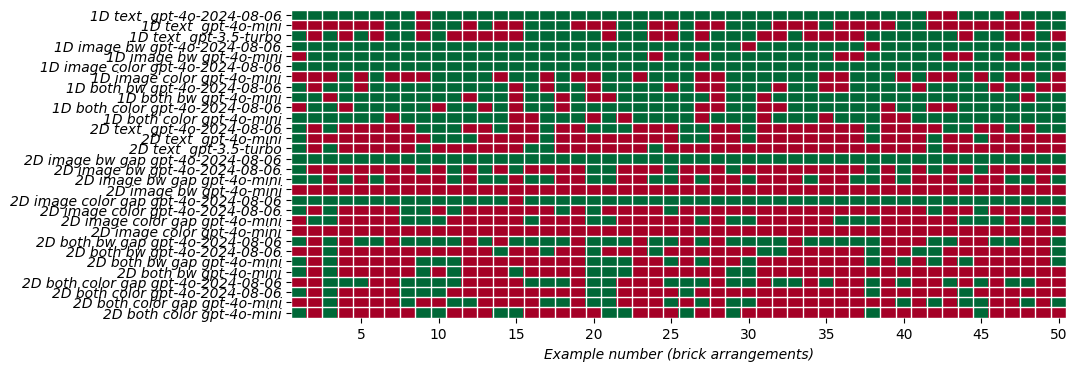

In [382]:
import matplotlib as mlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

df = pd.DataFrame(indexlist)
df.columns =['dimension', 'modality', 'color', 'gap', 'model']

for x in individual_results_overall:
    modality = x['modality']
    dimension = x['dimension']
    color = x['color']
    gap = x['gap']
    model = x['model']
    for i in range(50):
        df.loc[(df['dimension']==dimension) & (df['modality']==modality) & (df['color']==color) & (df['gap']==gap) & (df['model']==model), f'{i+1}'] = int(x['individual_results'][i]['correct'])

df.set_index(['dimension', 'modality', 'color', 'gap', 'model'], inplace=True)

# Create x-axis labels by combining the multi-index
y_labels = [' '.join(map(str, idx)).replace('  ',' ').replace('turb','turbo') for idx in df.index]

# Plotting the heatmap with plt.imshow
plt.figure(figsize=(10, 5))  # Adjust the size if needed
ax = plt.gca()

# Display the heatmap
cax = ax.imshow(df, cmap='RdYlGn', aspect='auto')

# Adding white grid lines around each cell
ax.set_xticks(np.arange(-0.5, len(df.columns), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(df.index), 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
ax.tick_params(which='minor', size=0)

# Set the ticks and labels for the x-axis and y-axis
plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels, style='italic')
# plt.xticks(ticks=np.arange(0, len(df.columns), 4), labels=df.columns[::5])
plt.xticks(ticks=[4,9,14,19,24,29,34,39,44,49], labels=[5,10,15,20,25,30,35,40,45,50])
plt.xlabel('Example number (brick arrangements)', style='italic')

# Remove the black outline around the plot area
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show the plot with colorbar
plt.show()


In [326]:
# analyze 1D cases for the best performing images
performance_1d = df.query('dimension=="1D"').mean()
performance_1d_best = performance_1d.index[performance_1d==performance_1d.max()].tolist()
performance_1d_worst = performance_1d.index[performance_1d==performance_1d.min()].tolist()
print(f'Best performing 1D model: {performance_1d_best}') # 11/11
print(f'Worst performing 1D model: {performance_1d_worst}') # 4/11
performance_1d.min()
performance_1d.max()

# analyze 2d cases for the best performing images
performance_2d = df.query('dimension=="2D"').mean()
performance_2d_best = performance_2d.index[performance_2d==performance_2d.max()].tolist()
performance_2d_worst = performance_2d.index[performance_2d==performance_2d.min()].tolist()
print(f'Best performing 2d model: {performance_2d_best}') # 8/11
print(f'Worst performing 2d model: {performance_2d_worst}') # 0/11
performance_2d.min()

Best performing 1D model: ['26', '29']
Worst performing 1D model: ['27']
Best performing 2d model: ['1']
Worst performing 2d model: ['2', '4', '5', '6', '7', '19', '23', '28', '33', '34', '35', '36', '37', '39', '46', '48']


0.0

In [178]:
df

0      1      2      3      4  \
dimension modality color model                                                  
1D        text           gpt-4o-2024-08-06   True   True   True   True   True   
                         gpt-4o-mini        False  False  False  False  False   
                         gpt-3.5-turb        True  False   True  False   True   
          image    bw    gpt-4o-2024-08-06   True   True   True   True   True   
                         gpt-4o-mini        False   True   True   True   True   
                   color gpt-4o-2024-08-06   True   True   True   True   True   
                         gpt-4o-mini        False  False  False   True  False   
          both     bw    gpt-4o-2024-08-06   True  False   True   True  False   
                         gpt-4o-mini         True   True  False   True   True   
                   color gpt-4o-2024-08-06  False   True   True  False   True   
                         gpt-4o-mini         True   True   True   True   True   
2D        text           gpt-4o-2024-08-06   True  False   True  False  False   
                         gpt-4o-mini         True  False  False  False  False   
                         gpt-3.5-turb        True  False   True  False  False   
          image    bw    gpt-4o-2024-08-06   True  False  False  False  False   
                         gpt-4o-mini        False  False  False  False  False   
                   color gpt-4o-2024-08-06   True  False   True  False  False   
                         gpt-4o-mini        False  False  False  False  False   
          both     bw    gpt-4o-2024-08-06  False  False   True  False  False   
                         gpt-4o-mini         True  False   True  False  False   
                   color gpt-4o-2024-08-06   True  False   True  False  False   
                         gpt-4o-mini         True  False   True  False  False   

                                                5      6      7      8      9  \
dimension modality color model                                                  
1D        text           gpt-4o-2024-08-06   True   True   True  False   True   
                         gpt-4o-mini        False   True   True  False   True   
                         gpt-3.5-turb       False   True   True  False   True   
          image    bw    gpt-4o-2024-08-06   True   True   True   True   True   
                         gpt-4o-mini         True   True   True   True   True   
                   color gpt-4o-2024-08-06   True   True   True   True   True   
                         gpt-4o-mini         True  False  False  False   True   
          both     bw    gpt-4o-2024-08-06   True   True   True   True   True   
                         gpt-4o-mini         True   True   True   True   True   
                   color gpt-4o-2024-08-06   True   True   True   True  False   
                         gpt-4o-mini         True  False   True   True   True   
2D        text           gpt-4o-2024-08-06  False  False  False   True   True   
                         gpt-4o-mini        False  False  False  False   True   
                         gpt-3.5-turb       False  False  False   True  False   
          image    bw    gpt-4o-2024-08-06  False  False  False   True  False   
                         gpt-4o-mini        False  False  False  False  False   
                   color gpt-4o-2024-08-06  False  False   True   True  False   
                         gpt-4o-mini        False  False  False  False  False   
          both     bw    gpt-4o-2024-08-06  False  False  False  False  False   
                         gpt-4o-mini        False  False  False   True  False   
                   color gpt-4o-2024-08-06  False  False   True   True   True   
                         gpt-4o-mini        False  False  False   True   True   

                                            ...     40     41     42     43  \
dimension modality color model              ...                               


TypeError: Image data of dtype object cannot be converted to float

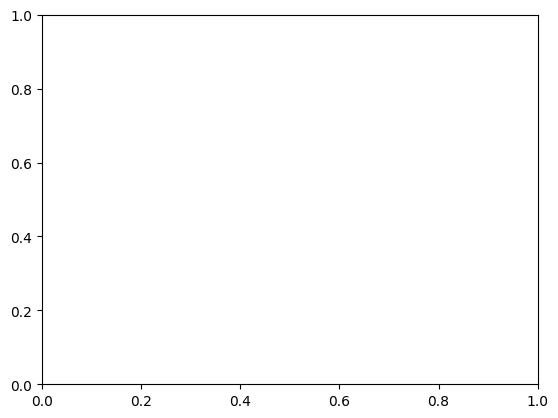